In [77]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.stats as stats
from torch.distributions import Distribution
from sklearn.neighbors import KernelDensity
import torch
import pandas as pd

from tqdm import tqdm
from sbi.inference import SNPE
from sbi.neural_nets import posterior_nn
from sbi.utils import BoxUniform
# from sbi.inference import load_posterior


plt.rcParams.update({
    'figure.figsize':(7,7),
    'xtick.major.width':1,
    'ytick.major.width':1,
    'xtick.minor.width':1,
    'ytick.minor.width':1,
    'xtick.major.size':8,
    'ytick.major.size': 6,
    'xtick.minor.size':3,
    'ytick.minor.size':3,
    'font.family':'STIXGeneral',
    'font.size':16,
#    'xtick.top':True,
#    'ytick.right':True,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'mathtext.fontset': 'cm',
    'mathtext.rm': 'serif'})   

def make_plot_nice(ax):
    """
    """    
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')  # or 'bottom'                                                    
    ax.tick_params(direction='in',axis='both',which='minor',length=3,width=1,labelsize=14)
    ax.tick_params(direction='in',axis='both',which='major',length=6,width=1,labelsize=14)
    ax.minorticks_on()  
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.)

    return

from sklearn.model_selection import train_test_split

import seaborn as sns

import itertools
from matplotlib.lines import Line2D
import random

import astropy.constants as const
import astropy.units as u

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from torch.distributions import constraints

import corner


# read data

Note, I'm going to train this model with only 1% of the generated dataset. Otherwise it takes too long unfortunately. Future work should train this with more data!

In [13]:
### import my data :D 
dat = np.load('data/trts_data_with_errors.npz')
features_all = dat['features'] ### 20 RVs, 20 timestamps
labels_all = dat['labels'] ### v0, K, w, phi_0, e, P
logPs = np.log10(labels_all[:,-1:])
# ws = labels[:,2]
# sin_ws = np.sin(labels[:,2:3])
# cos_ws = np.cos(labels[:,2:3])
# labels = np.hstack([labels[:,:2], sin_ws, cos_ws, labels[:,3:-1], logPs]) # comment out unless i want to train on logPeriod
labels_all = np.hstack([labels_all[:,:-1], logPs])

In [14]:
### downselect
# Create a local random generator with a fixed seed
rng = np.random.default_rng(seed=42)
N=int(5e4)
data_sel = rng.integers(0, len(features_all), size=N)
features=features_all[data_sel]
labels=labels_all[data_sel]

# Normalize, select training and test data

In [15]:
def normalize_inputs(input_data):
    """
    input_data must be a numpy array of shape (N, 40)
    where the first 20 columns are RVs 
    and the second 20 columns are times of the observations.
    Returns (N, 42) array: 20 normalized RVs, 20 normalized times, v0_est, K_est
    """
    input_RVs = input_data[:, :20]
    input_times = input_data[:, 20:]

    # Compute RV normalizations
    v_max = np.max(input_RVs, axis=1, keepdims=True)
    v_min = np.min(input_RVs, axis=1, keepdims=True)
    v0_est = np.mean(input_RVs, axis=1, keepdims=True)
    K_est = (v_max - v_min) / 2

    # Normalize RVs
    normed_rvs = (input_RVs - v_min) / (v_max - v_min + 1e-8)  # add epsilon to avoid div by zero

    # Compute time normalizations
    t_max = np.max(input_times, axis=1, keepdims=True)
    t_min = np.min(input_times, axis=1, keepdims=True)

    # Normalize times
    normed_times = (input_times - t_min) / (t_max - t_min + 1e-8)

    return np.hstack([normed_rvs, normed_times, v0_est, K_est])    

def normalize_outputs(output_data, min_tr, max_tr):
    """
    normalize outputs based on the min/max of the training data
    normalized column-wise (ie so that all orbital periods are btwn 0--1, etc)
    """
    # column-wise unnormalization based on training data
    # max_tr = np.max(training_data, axis=0)
    # min_tr = np.min(training_data, axis=0)
    normed_outputs = (output_data - min_tr)/(max_tr - min_tr)
    return normed_outputs

def unnormalize_outputs(output_data, min_tr, max_tr):
    # max_tr = np.max(training_data, axis=0)
    # min_tr = np.min(training_data, axis=0)
    unnormed_outputs = (output_data*(max_tr - min_tr)) + min_tr
    return unnormed_outputs

In [16]:
### perform the train/test split prior to normalizing
X_train_unnorm, X_test_unnorm, y_train_unnorm, y_test_unnorm = train_test_split(
    features, labels,test_size=0.2, random_state=33
    )

min_tr = np.min(y_train_unnorm, axis=0)
max_tr = np.max(y_train_unnorm, axis=0) 

In [17]:
### normalize
## normalize training and test data
X_train_numpy = normalize_inputs(X_train_unnorm)
X_test_numpy = normalize_inputs(X_test_unnorm)

y_train_numpy = normalize_outputs(y_train_unnorm, min_tr, max_tr)
y_test_numpy = normalize_outputs(y_test_unnorm, min_tr, max_tr)

# the model

First we need to define a prior that sbi can understand. This can just come from our giant dataset of model parameters, but we'll smooth them into a KDE first with the class below:

In [18]:
### make priors based on y training data.
class KDEPrior(Distribution):
    def __init__(self, samples, bandwidth=0.2):
        super().__init__(validate_args=False)
        self.device = samples.device
        self.samples = samples
        self.kde = KernelDensity(bandwidth=bandwidth)
        self.kde.fit(samples.cpu().numpy())

    def log_prob(self, x):
        x_np = x.cpu().numpy()
        log_probs = self.kde.score_samples(x_np)
        return torch.tensor(log_probs, device=self.device, dtype=torch.float32)

    def sample(self, sample_shape=torch.Size()):
        indices = torch.randint(0, len(self.samples), sample_shape)
        return self.samples[indices]

    @property
    def support(self):
        return constraints.real  # or `real_vector` if you want more specific
    
    @property
    def mean(self):
        return self.samples.mean(dim=0)

    @property
    def stddev(self):
        return self.samples.std(dim=0)

In [19]:
## we'll use _all_ of the normalized labels to define a "normalized" prior
all_normalized_labels = normalize_outputs(labels, min_tr, max_tr)

simulated_prior_samples = torch.tensor(all_normalized_labels, dtype=torch.float32)  # shape [N, 6]
prior = KDEPrior(simulated_prior_samples)

now we can actually define the model with some hyperparameters

In [52]:
### do the inference part...
# Set some parameters of our flow..
nhidden = 20
nblocks = 10#5

# This sets up the flow
anpe = SNPE(
        prior=prior,
        density_estimator=posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks))

In [53]:
# give the model the training data
anpe.append_simulations(torch.as_tensor(y_train_numpy.astype(np.float32)), # "theta"
                        torch.as_tensor(X_train_numpy.astype(np.float32))) # x

In [54]:
# create the estimator (train)
p_x_y_estimator = anpe.train(max_num_epochs=3000, stop_after_epochs=100) 

 Neural network successfully converged after 1127 epochs.

In [55]:
hatp_x_y = anpe.build_posterior(p_x_y_estimator)

In [ ]:
### !! SAVE THE MODEL !!
### save the model:
torch.save(hatp_x_y, 'models/sbi_model_longtraining.pt')

# to reload
# hatp_x_y = torch.load('models/sbi_model.pt', weights_only=False) # trained on 5e+4 points for 1000 epochs; did not converge.
# hatp_x_y = torch.load('models/sbi_model_longtraining.pt', weights_only=False) # trained on 5e+4 points, successfully converged after 1127 epochs

# Test the sbi model

First, for a random subset of the test data we'll sample the posterior, assume it's gaussian, and compute the median/uncertainty of the distribution in each parameter. This is not super rigorous, but it's a start.

In [73]:
random_tests = np.random.randint(low=0, high=len(y_test_numpy), size=2000)
random_tests.shape

(2000,)

In [74]:
y_test = y_test_numpy[random_tests]
X_test = X_test_numpy[random_tests]

med_samples = []
unc_samples = []

pick_index = 0
param_names = ['v0','K','w','phi0','e','P']
for i,specific_x_test in enumerate(X_test):

    specific_x_test_tensor = torch.tensor(specific_x_test, dtype=torch.float32)
    samples = hatp_x_y.sample((1000,),x=specific_x_test_tensor).numpy()

    unnormed_samples = unnormalize_outputs(samples, min_tr=min_tr, max_tr=max_tr)
    med_all = np.median(unnormed_samples, axis=0)
    med_samples.append(med_all)


    unc_all = (np.percentile(unnormed_samples,84, axis=0)-np.percentile(unnormed_samples,16, axis=0))/2.0
    unc_samples.append(unc_all)

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 37362.08it/s]


In [75]:
med_samples = np.array(med_samples)
unc_samples = np.array(unc_samples)

In [113]:
# Replace these with your actual hex codes
# hex_colors = [
#     '#4281A4', '#4595A5', '#48A9A6', 
#     '#96C4C0', '#E4DFDA', '#D4B483', 
#     '#D0A17D', '#CB8D77', '#C1666B'
# ]

# hex_colors = [
#     "#4281A4", "#4595A5", "#48A9A6","#D4B483","#D0A17D","#CB8D77","#C1666B"

# ]

# hex_colors = [
#     "#FF5964","#FF7D5E","#FFC452","#FFE74C","#FFF3A6","#B5F28F",
#     "#6BF178","#50CCBC","#35A7FF"
# ]

hex_colors=["#FF5964","#FF7D5E","#FFC452","#50CCBC","#35A7FF"]


# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', hex_colors)


-144.02767620383568 115.77995716759742
0.00442375607907496 285.82478384650875
1.6299403303596415e-05 6.283124432877171
0.00011554009678238497 0.9999522290990253
0.0001049481884528 0.989065230181656
0.15007277380913311 7.994449191340791


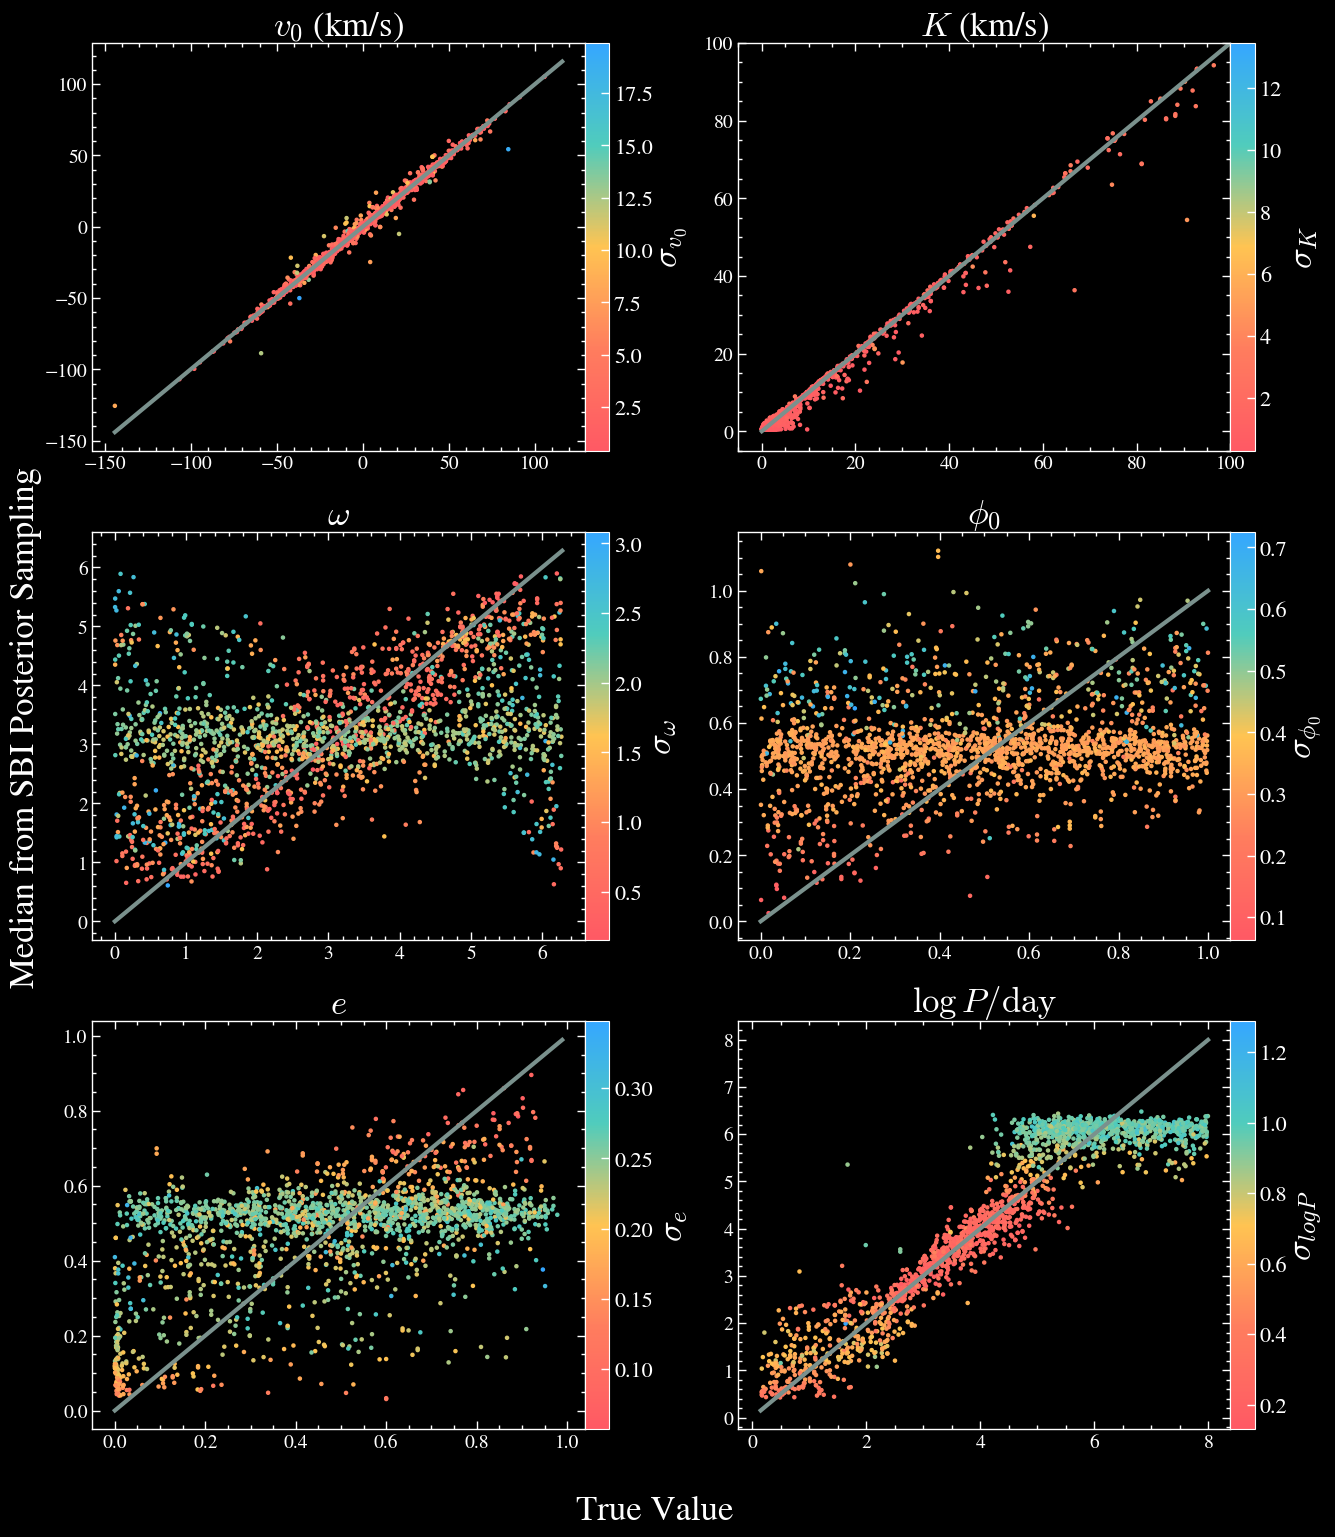

In [115]:
X_unnormed = X_test_unnorm[random_tests]
y_unnormed = y_test_unnorm[random_tests]#[:,pick_index]
# fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3, figsize=[20,12])
with plt.style.context("dark_background"):
    fig, [[ax1,ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2, figsize=[15,18])
    plt.subplots_adjust(wspace=.25)
    ax_list = [ax1,ax2,ax3,ax4,ax5,ax6]
    param_names = [r"$v_0$ (km/s)", r"$K$ (km/s)", r'$\omega$', r'$\phi_0$', r'$e$', r'$\log{P/\rm{day}}$']
    param_names_latex = ["v_0", "K", '\omega', '\phi_0', 'e', 'logP']

    plot='cmap' # 'errbar' or 'cmap'

    for i in range(med_samples.shape[1]):
        ax = ax_list[i]
        # if i==2 or i==3 or i==4 or i==5:
        if plot=='errbar':
            ax.errorbar(y_unnormed[:,i], med_samples[:,i], yerr=unc_samples[:,i], marker='o', capsize=3, ls='', 
                        markersize=5,zorder=0, c='#99C2A2',rasterized=True)
        
        if plot=='cmap':
            ob = ax.scatter(y_unnormed[:,i], med_samples[:,i], s=5, c=unc_samples[:,i], cmap=custom_cmap)#'magma')
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0)
            cbar = fig.colorbar(ob, cax=cax, orientation='vertical')
            cbar.set_label(r'$\sigma_{%s}$'%param_names_latex[i], fontsize=25)

        mi = min(y_test_unnorm[:,i])
        ma = max(y_test_unnorm[:,i])
        print(mi, ma)
        ax.plot([mi,ma],[mi,ma], c='#7A918D', linewidth=3) 
        ax.set_title(param_names[i], fontsize=25) 
        make_plot_nice(ax)  



    fig.text(0.5, 0.06, "True Value", ha='center', fontsize=25)
    fig.text(0.07, 0.5, "Median from SBI Posterior Sampling", rotation='vertical', va='center', fontsize=25)
    # ax6.set_xscale('log')
    # ax6.set_yscale('log')
    ax2.set_xlim(-5, 100)
    ax2.set_ylim(-5, 100)
plt.savefig("plots/sbi_performance_predvstrue.pdf", dpi=300, bbox_inches="tight")


Drawing 40000 posterior samples: 100%|██████████| 40000/40000 [00:00<00:00, 108086.48it/s]


4.279804134816224 4.139273209200748


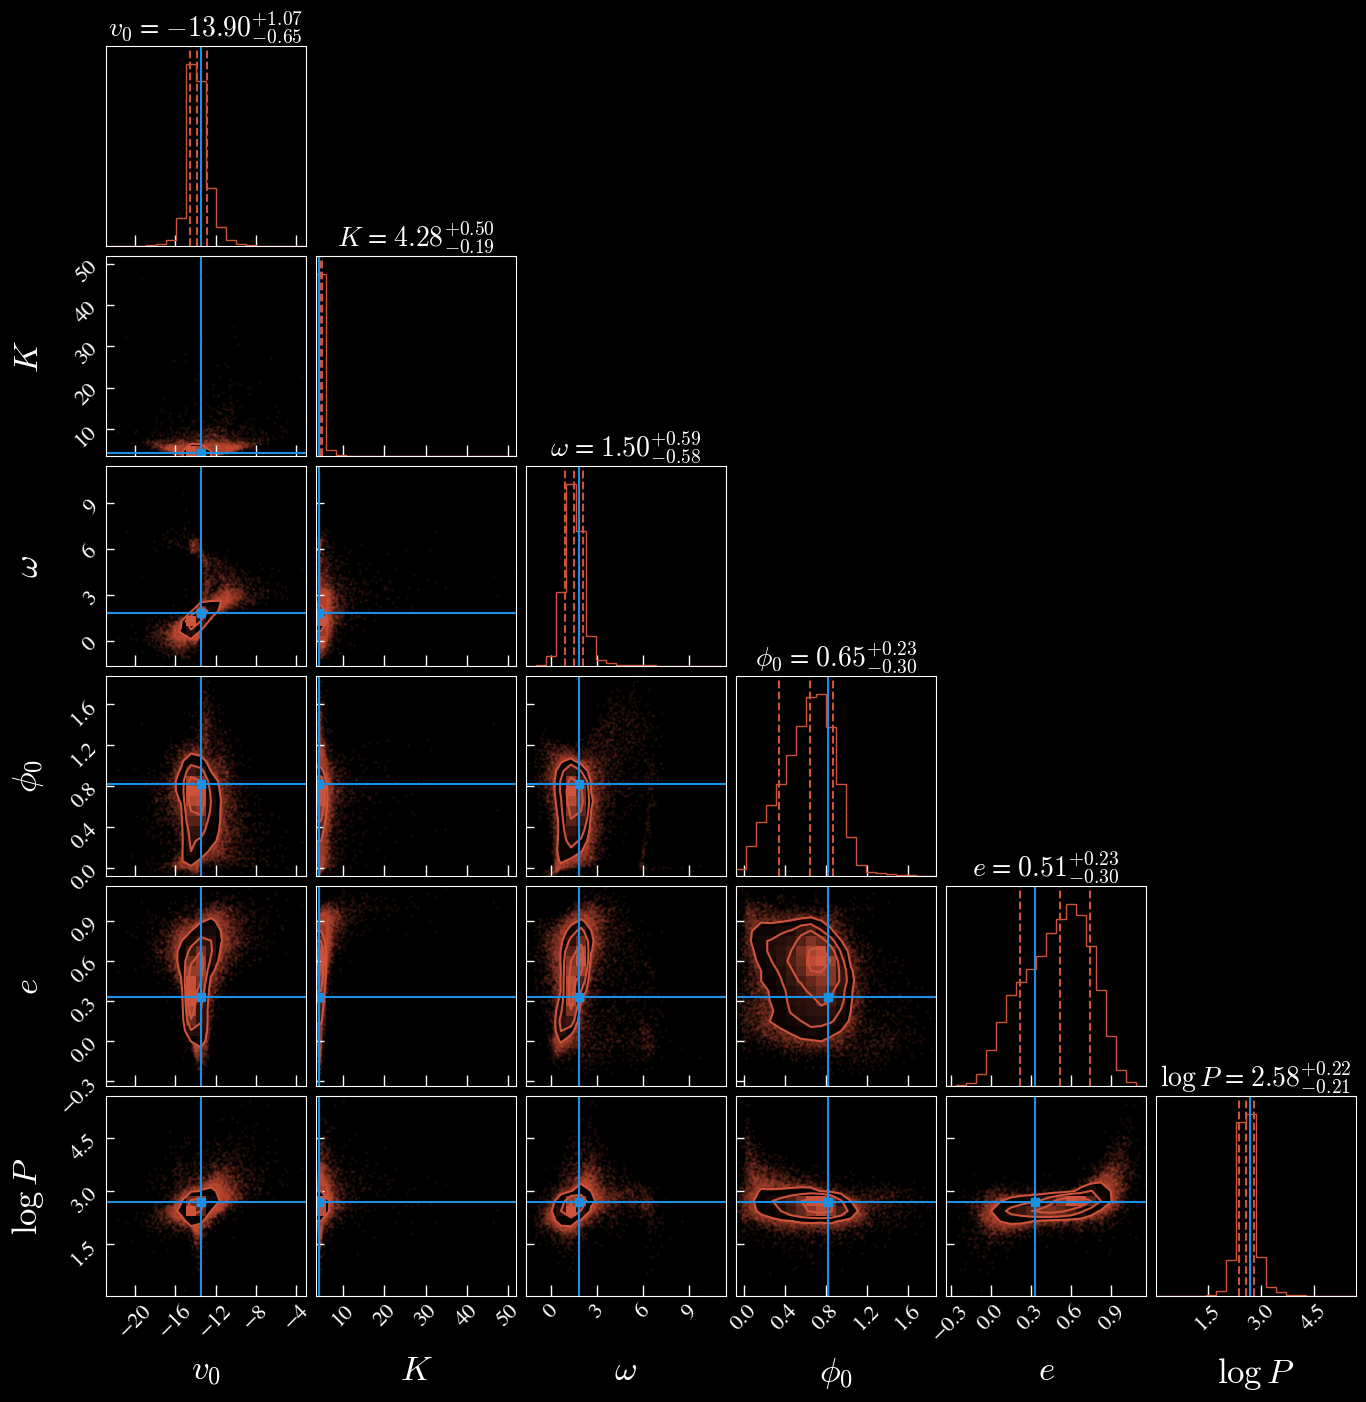

In [105]:
# an example corner plot?
# Pick an index
idx = 555 #1000  # choose which object you want

# Get the observation x (42D input)
specific_x_test = torch.tensor(X_test_numpy[idx], dtype=torch.float32)
true_params = y_test_unnorm[idx]  # <-- True [v0, K, w, phi0, e, logP]

# Ps = 10**true_params[-1:]
# true_params = np.concatenate([true_params[:-1], Ps])

# Draw samples from the posterior
samples = hatp_x_y.sample((40000,), x=specific_x_test).numpy() 
unnormed_samples = unnormalize_outputs(samples, min_tr=min_tr, max_tr=max_tr)

# sampled_Ps = 10**unnormed_samples[:,-1:]
# unnormed_samples = np.hstack([unnormed_samples[:,:-1], sampled_Ps])


# print("K samples range: ", np.min(unnormed_samples[:,1]), np.max(unnormed_samples[:,1]))
# print("True K value: ", true_params[1])

print(np.median(unnormed_samples[:,1]), true_params[1])
#
# Parameter names
param_names = [r'$v_0$', r'$K$', r'$\omega$', r'$\phi_0$', r'$e$', r'$\log{P}$']

# Plot using corner
with plt.style.context("dark_background"):

    figure = corner.corner(unnormed_samples,
                        labels=param_names,
                        truths=true_params, 
                        color='#CD533B',
                        truth_color='#1A8FE3',
                        show_titles=True,
                        title_fmt='.2f',
                        quantiles=[0.16, 0.5, 0.84],
                        title_kwargs={"fontsize": 20},
                        label_kwargs={"fontsize":25})
plt.savefig("plots/example_corner.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [100]:
true_params

array([-13.42602642,   4.13927321,   1.87490103,   0.82279957,
         0.33077512,   2.67799707])

visualize RV curves with samples from the posterior.


In [101]:
## functions to solve keplers equation, get the true anomaly, and get RVs
def solve_kepler(M, e, tol=1e-10, max_iter=100):
    """Vectorized Kepler solver using Newton-Raphson with safety."""
    M = np.asarray(M)
    e = np.asarray(e)

    # Ensure shapes are compatible
    if M.shape != e.shape:
        e = np.full_like(M, e)

    E = M.copy()  # initial guess

    for _ in range(max_iter):
        f = E - e * np.sin(E) - M
        f_prime = 1 - e * np.cos(E)
        delta = f / f_prime

        # Protect against divide-by-zero or overflow
        delta = np.where(np.isfinite(delta), delta, 0.0)
        E_new = E - delta

        # Convergence mask
        if np.all(np.abs(delta) < tol):
            break
        E = E_new

    # Final sanity check
    E = np.where(np.isfinite(E), E, np.nan)
    return E

def true_anomaly(E, e):
    """Convert eccentric anomaly E to true anomaly ν safely."""
    sqrt_1_plus_e = np.sqrt(np.clip(1 + e, 0, None))
    sqrt_1_minus_e = np.sqrt(np.clip(1 - e, 0, None))

    sin_E2 = np.sin(E / 2)
    cos_E2 = np.cos(E / 2)

    # Replace NaNs with 0 to avoid propagating errors
    sin_E2 = np.nan_to_num(sin_E2)
    cos_E2 = np.nan_to_num(cos_E2)

    return 2 * np.arctan2(
        sqrt_1_plus_e * sin_E2,
        sqrt_1_minus_e * cos_E2
    )

def radial_velocity(t, params, logP=False):
    """
    t : times at which to compute RV
    v0 : systemic velocity
    K : RV semiamplitude
    w : arg of periapsis
    e : eccentricity
    phi_0 : mean anomaly phase offset
    P : period (in same units as t)
    """
    v0, K, w, phi_0, e, P = params

    if logP==True:
        P=10**P

    M = 2 * np.pi * t / P - phi_0
    E = solve_kepler(M % (2 * np.pi), e)
    nu = true_anomaly(E, e)
    vr = v0 + K * (np.cos(nu + w) + e * np.cos(w))
    return vr

Drawing 10 posterior samples: 100%|██████████| 10/10 [00:00<00:00, 1269.35it/s]
/var/folders/q2/m18s57611677cjnvtmvry2v80000gn/T/ipykernel_33864/3048137659.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('magma_r')
Drawing 10 posterior samples: 100%|██████████| 10/10 [00:00<00:00, 2379.88it/s]


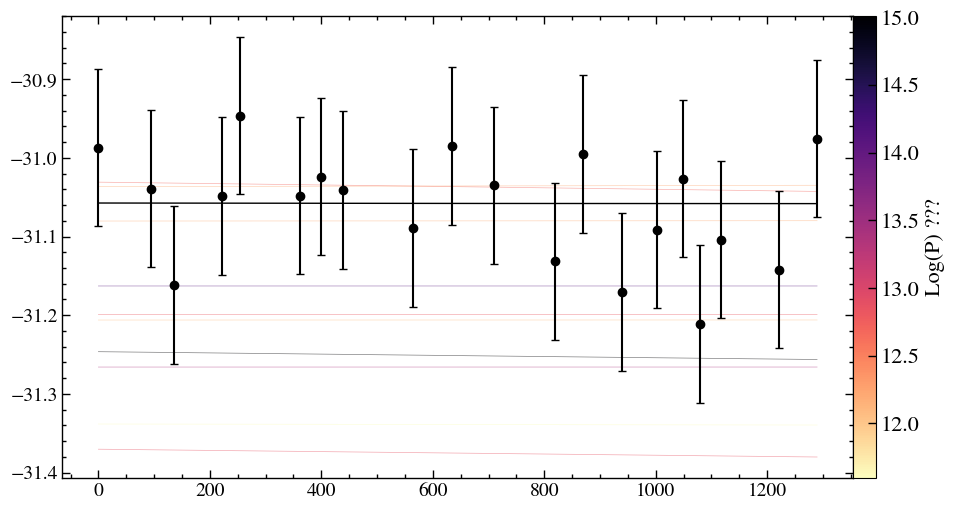

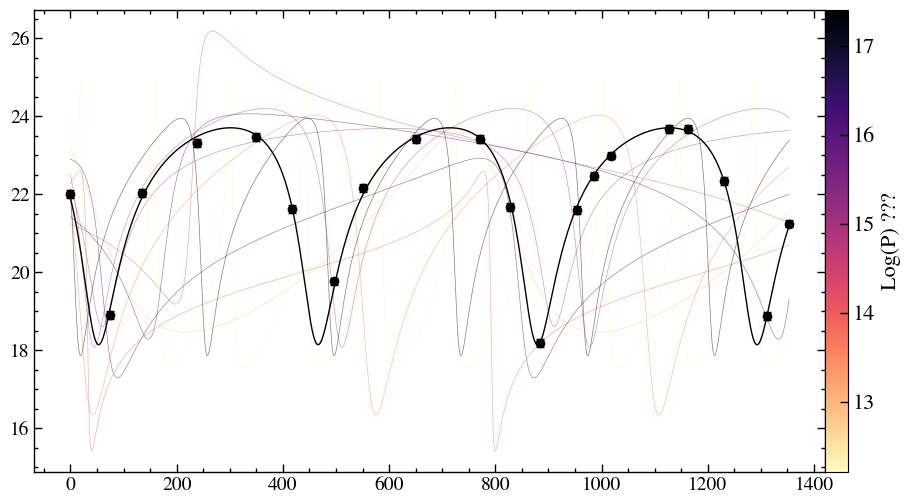

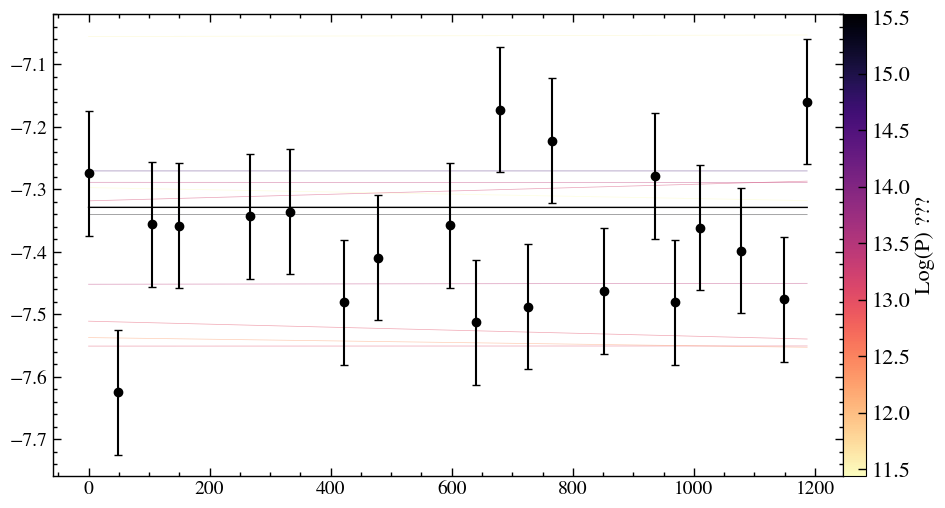

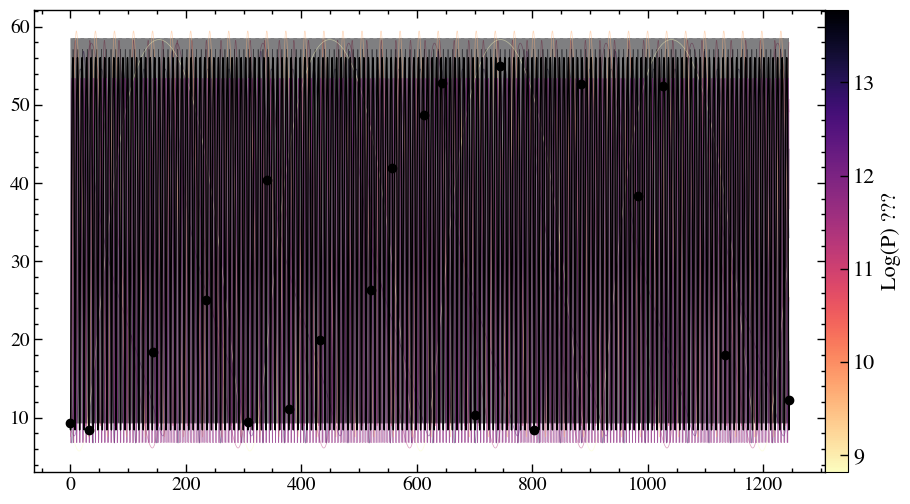

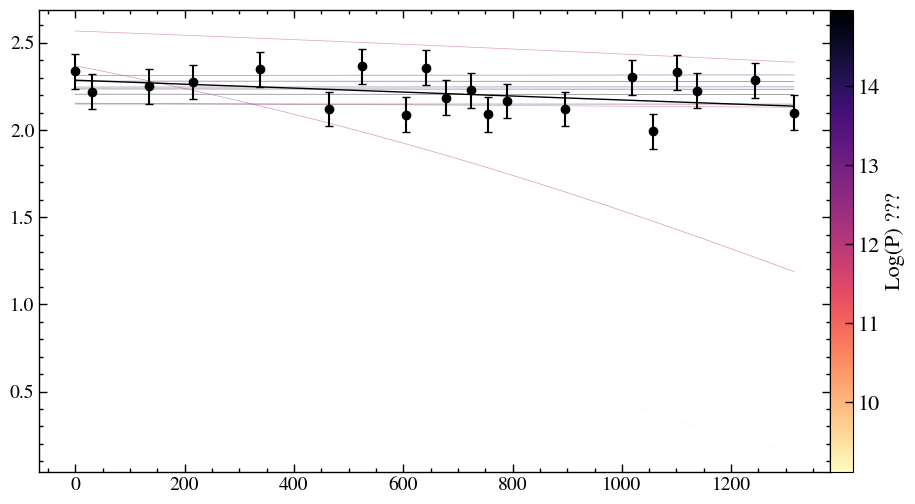

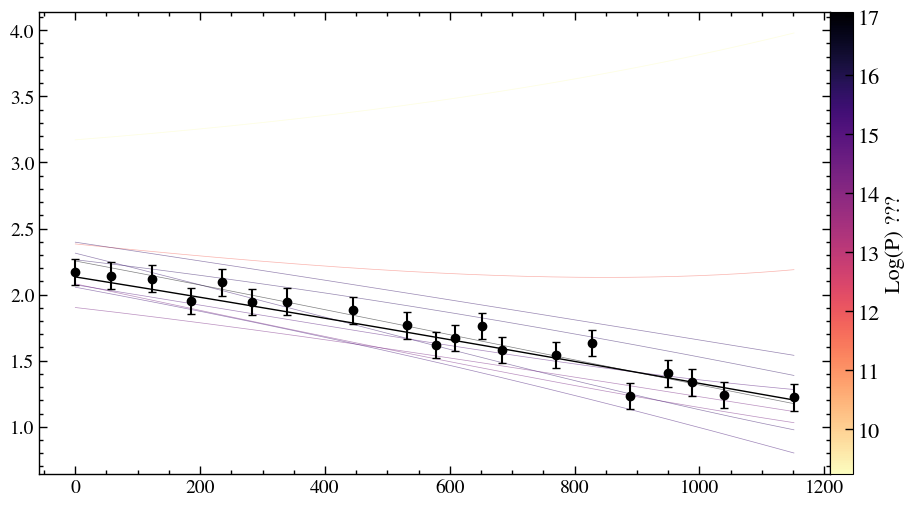

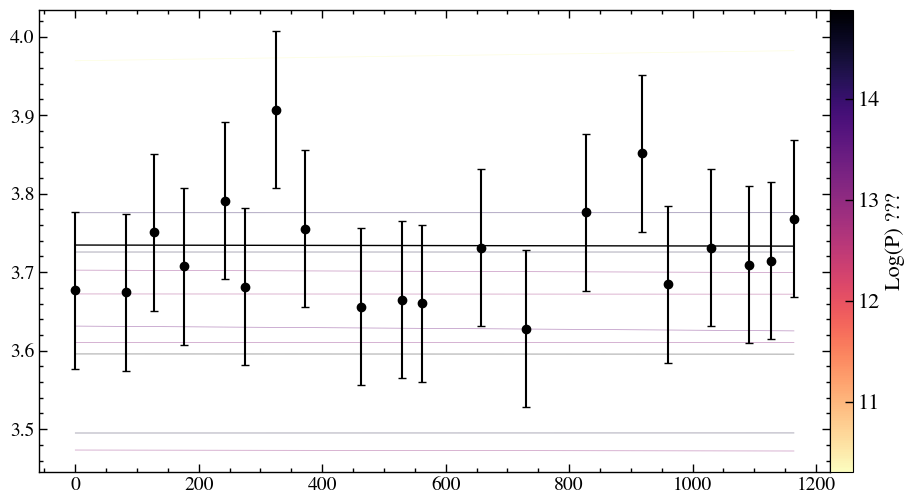

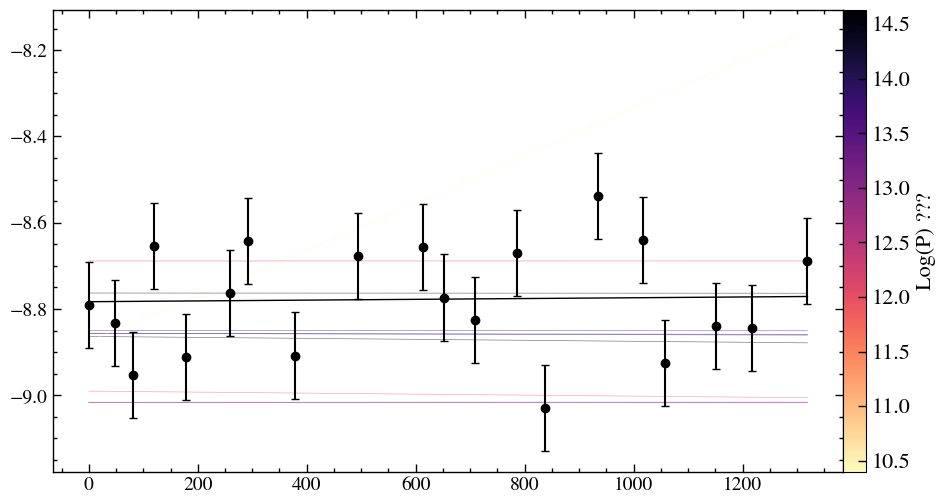

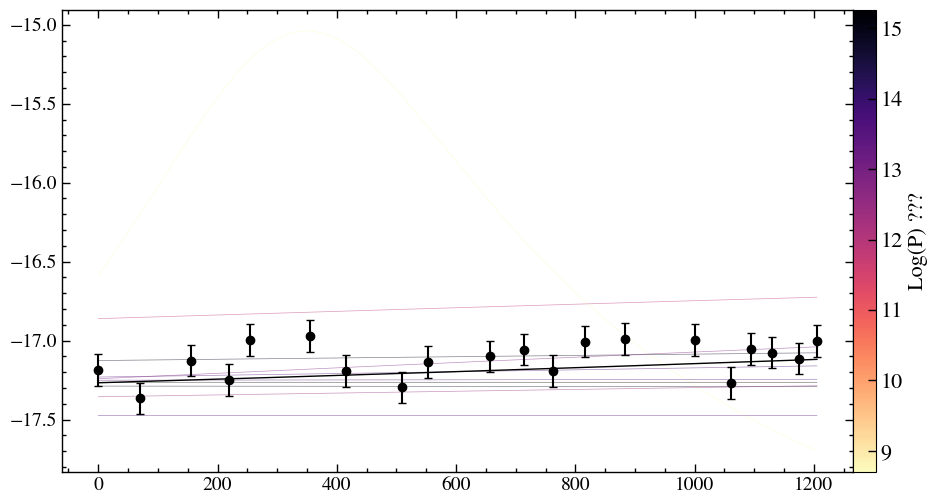

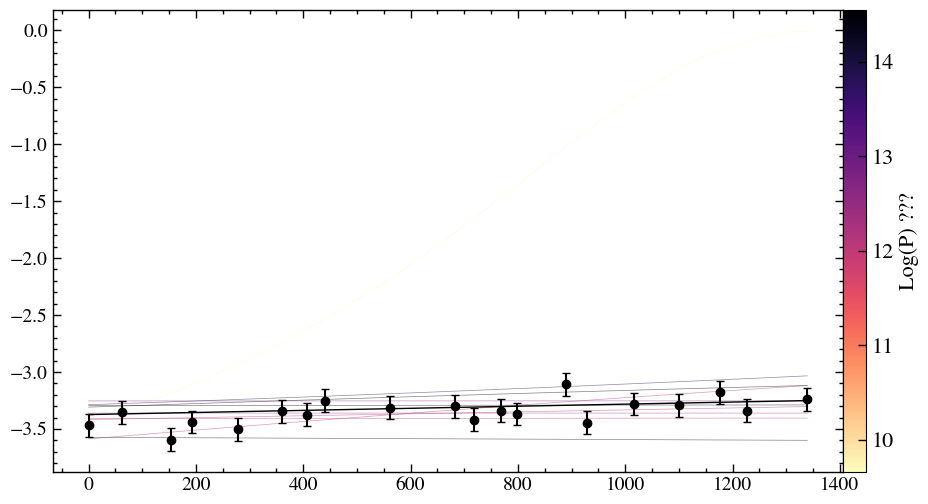

In [103]:
### plot an RV curve with samples of the posterior overlayed.2
# idx = 334

idx_to_plot = np.random.randint(0, len(X_test_numpy), 10)

for idx in idx_to_plot:
    vs = X_test_unnorm[idx][:20]
    ts = X_test_unnorm[idx][20:40]

    true_params = y_test_unnorm[idx]

    specific_x_test = X_test_numpy[idx]

    samples = hatp_x_y.sample((10,), x=specific_x_test).numpy() 
    unnormed_samples = unnormalize_outputs(samples, min_tr=min_tr, max_tr=max_tr)


    log_probs = hatp_x_y.log_prob(samples, x=specific_x_test)

    # Normalize log_probs to [0, 1]
    log_probs_np = log_probs.detach().cpu().numpy()  # Make sure it's numpy
    norm = mcolors.Normalize(vmin=np.min(log_probs_np), vmax=np.max(log_probs_np))
    cmap = cm.get_cmap('magma_r')


    ts_model = np.linspace(0, max(ts), 100000)

    vs_true = radial_velocity(ts_model, true_params, logP=True)

    fig, ax = plt.subplots(figsize=[12,6])


    for samp, logP in zip(unnormed_samples, log_probs):

        vs_mod = radial_velocity(ts_model, samp, logP=True)
        color = cmap(norm(logP))  # Map logP -> [0,1] -> color
        ax.plot(ts_model, vs_mod, lw=.5, c=color, alpha=0.5)

    ax.errorbar(ts, vs, yerr=0.1, marker='o', capsize=3, linestyle='', c='k')
    ax.plot(ts_model, vs_true, c='k', lw=1)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Log(P) ???', pad=0)
    make_plot_nice(ax)